## Librerías

In [1]:
!python -m pip install ambiance
!pip install -q nrlmsise00
!pip install -qU 'nrlmsise00[dataset]'
!pip install -q spaceweather

In [1]:
from ambiance import Atmosphere
from nrlmsise00.dataset import msise_4d
from datetime import datetime
import spaceweather as sw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from tqdm import tqdm
import time
# Ignorar el FutureWarning específico
warnings.filterwarnings("ignore", category=FutureWarning, module="nrlmsise00.dataset.core")
#NRLMSISE-00 usa datos del clima espacial.  Esos datos tienen que actualizarse
sw.update_data()

/home/jupitergeci/anaconda3/lib/python3.11/site-packages/nrlmsise00/dataset/__init__.py:27: UserWarning: The xarray 4d interface is experimental.
  warn("The xarray 4d interface is experimental.", UserWarning)


# <center> Mecánica de Medios Continuos
# <center> Atmósferas
# <center> Alejandro Murillo González
.

---



---



Objetivo: El objetivo de esta trabajo es comparar los distintos modelos de atmósferas, frente al modelo de atmósfera empírica NRLMSISE-00 (US Naval Research Laboratory mass spectrometer and incoherent scatter radar). Este modelo puede darnos información de la atmósfera en distintas ubicaciones en la Tierra, épocas del año, horas del día e incluso épocas del ciclo solar. Hay un paquete en Python que permite obtener datos del modelo. Una explicación del paquete puede encontrarse en el Notebook de modelos atmosféricos del profesor

## Obtención de datos

1. Obtener los datos de la atmósfera desde la superficie hasta 100 km en una ubicación, fecha y hora específica cada 50 metros. Para ello puede usar el día y lugar de nacimiento. Asuma para la hora de nacimiento las 12 m (medio día).

In [3]:
# Configura los parámetros de entrada
date = datetime(2001, 6, 16, 12,0,0)  # Fecha específica
altitud = 2.125  #km
zs = np.arange(0,100000+50,50)  # Altitudes en kilómetros
latitud = 6.1559 # Latitud en grados
longitud =  75.3737  # Longitud en grados

# Realiza el cálculo de la atmósfera
ds = msise_4d(date, zs/1e3, latitud, longitud)
ρs_emp=np.array(ds["rho"]).flatten()*1e3
Ts_emp=np.array(ds["Talt"]).flatten()


In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 1, alt: 2001, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 2001-06-16T12:00:00
  * alt      (alt) float64 0.0 0.05 0.1 0.15 0.2 ... 99.8 99.85 99.9 99.95 100.0
  * lat      (lat) float64 6.156
  * lon      (lon) float64 75.37
Data variables: (12/15)
    He       (time, alt, lat, lon) float64 1.277e+14 1.271e+14 ... 8.629e+07
    O        (time, alt, lat, lon) float64 0.0 0.0 0.0 ... 3.993e+11 3.979e+11
    N2       (time, alt, lat, lon) float64 1.902e+19 1.894e+19 ... 7.73e+12
    O2       (time, alt, lat, lon) float64 5.103e+18 5.081e+18 ... 1.569e+12
    Ar       (time, alt, lat, lon) float64 2.275e+17 2.265e+17 ... 7.927e+10
    rho      (time, alt, lat, lon) float64 0.00117 0.001165 ... 4.584e-10
    ...       ...
    Texo     (time, alt, lat, lon) float64 1.027e+03 1.027e+03 ... 1.027e+03
    Talt     (time, alt, lat, lon) float64 300.2 299.8 299.5 ... 161.9 162.1
    lst      (time, lon) float64 17.02
    Ap       (time) int32 5
    f107     (time) float64 196.9
    f107a    (time) float64 151.3

## Presión empírica

2. Usando los datos de composición de la atmósfera, calcule la presión atmosférica a cada altura. Asuma para ello la ecuación de estado de gas ideal. Haga gráficos de temperatura, densidad y presión con la altura, usando la convención en ciencias atmosféricas de poner la altura en el eje y.

La ecuación de estado del gas ideal $PV=nRT$ puede escribirse como:

$$P=\frac{\rho RT}{Mmol}$$




In [5]:
def presion(dens,T,mmol):
  R = 8.31446261815324
  return dens*R*T/mmol

### Cálculo de la masa molar

La masa molar $M_{mol}$ de la atmosfera se puede calcular a partir de la densidad de partículas proporcionadas en la atmosfera empírica para cada molécula presente en la atmosfera, esta masa molar cambiará con la altura debido a que las densidades de numero de partículas por cm³ cambia con la altura.

Para calcular la masa molar promedio en cada altura se hace uso de la fórmula:

$$\langle Mmol\rangle = \frac{\sum_i^{N} n_i m_i}{\sum_i^{N} n_i}$$

En esta fórmula $N$ es el numero de tipos de moléculas que componen la atmósfera, $n_i$ es la densidad de particulas por cm$³$ de cada molécula, y $m_i$ es la masa molar de cada tipo de molécula.

In [6]:

# Densidades de numero de partículas por cm³
He = np.array(ds["He"]).flatten()
O = np.array(ds["O"]).flatten()
N2 = np.array(ds["N2"]).flatten()
O2 = np.array(ds["O2"]).flatten()
Ar = np.array(ds["Ar"]).flatten()
H = np.array(ds["H"]).flatten()
N = np.array(ds["N"]).flatten()

# Masa molar de cada molécula
mmol= np.array([4.002602,15.999,28.0134,31.999,39.948,1.00784,14.0067])

# Se almacena la información en un DataFrame de pandas

comp = pd.DataFrame()
comp["Molecula"]= ["He","O","N2","O2","Ar","H","N"]
comp["Mmolar"] = mmol
comp["n"] = [He,O,N2,O2,Ar,H,N]


In [7]:

def Mmolar(n, mmol):
    """
    Calcula la masa molar promedio de la atmósfera a partir de las densidades de partículas
    y las masas molares de los gases.
    """
    masa_molar = sum(n[i] * mmol[i] for i in range(len(n)))/sum(n)
    return masa_molar


Masamolar= Mmolar(comp.n,comp.Mmolar)

print(f"Masa molar g/mol: {Masamolar[0]:.2f} g/mol")

Masa molar g/mol: 28.96 g/mol


### Cálculo de la presión empírica

In [8]:
R = 8.314 # Cte de los gases ideales J/mol K
atm = 101300 # Pascales

# presión empíria con ecuación de estado de gas ideal
ps_emp = presion(ρs_emp,Ts_emp,Masamolar*1e-3)

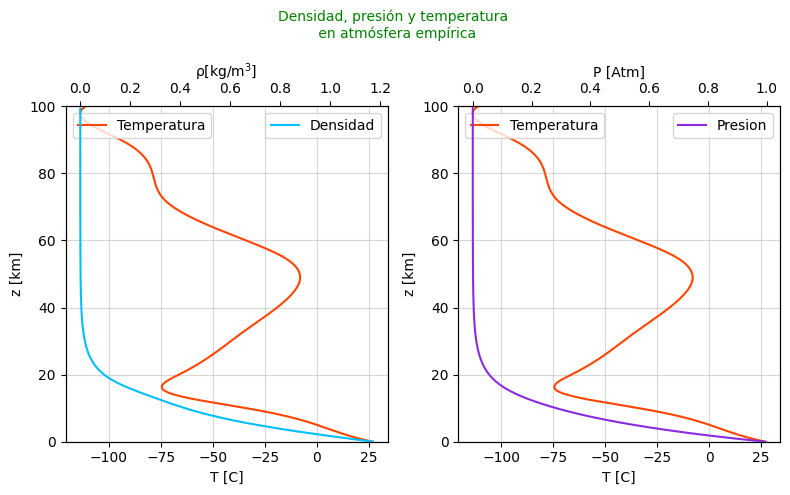

In [9]:
#----------------------------------#
#  GRÁFICA DE LA PRESIÓN EMPÍRICA  #
#----------------------------------#

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,5))
plt.suptitle("Densidad, presión y temperatura \n en atmósfera empírica", size=10,color="green")
# Dibujar el primer gráfico en el primer objeto Axes
ax1.plot(Ts_emp-273.15,zs/1e3,color="orangered",label='Temperatura')
axd1=ax1.twiny()
axd1.plot(ρs_emp,zs/1e3,color="deepskyblue",label="Densidad")
ax1.legend(loc='upper left')
axd1.legend()
ax1.set_xlabel("T [C]")
ax1.set_ylabel("z [km]")
axd1.set_xlabel("ρ[kg/m$^3$]")
#ax1.margins(0,0)
ax1.set_ylim(0,max(zs)/1e3)
ax1.grid(alpha=0.5)

# Dibujar el segundo gráfico en el segundo objeto Axes
ax2.plot(Ts_emp-273.15,zs/1e3,color="orangered",label='Temperatura')
axd2=ax2.twiny()
axd2.plot(ps_emp/atm,zs/1e3,color="blueviolet",label="Presion")
ax2.legend(loc='upper left')
axd2.legend()
ax2.set_xlabel("T [C]")
ax2.set_ylabel("z [km]")
axd2.set_xlabel("P [Atm]")
#ax2.margins(0,0)
ax2.set_ylim(0,max(zs)/1e3)
ax2.grid(alpha=0.5)

# Mostrar la figura
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
fig.tight_layout()
plt.show()

## Se deja una rutina para calcular los perfiles empíricos de densidad,temperatura y presión para una localidad y fecha específica.

In [10]:
def presion(dens,T,mmol):
  R = 8.31446261815324
  return dens*R*T/mmol

def Mmolar(n, mmol):
    """
    Calcula la masa molar promedio de la atmósfera a partir de las densidades de partículas
    y las masas molares de los gases.
    """
    masa_molar = sum(n[i] * mmol[i] for i in range(len(n)))/sum(n)
    return masa_molar



def atmosfera_emp(zs,fecha,lat,lon):
  # Configura los parámetros de entrad

  # Realiza el cálculo de la atmósfera
  ds = msise_4d(fecha, zs/1e3, lat, lon)
  ρs_emp=np.array(ds["rho"]).flatten()*1e3
  Ts_emp=np.array(ds["Talt"]).flatten()

  # Densidades de numero de partículas por cm³
  He = np.array(ds["He"]).flatten()
  O = np.array(ds["O"]).flatten()
  N2 = np.array(ds["N2"]).flatten()
  O2 = np.array(ds["O2"]).flatten()
  Ar = np.array(ds["Ar"]).flatten()
  H = np.array(ds["H"]).flatten()
  N = np.array(ds["N"]).flatten()

  # Masa molar de cada molécula
  mmol= np.array([4.002602,15.999,28.0134,31.999,39.948,1.00784,14.0067])

  # Se almacena la información en un DataFrame de pandas

  comp = pd.DataFrame()
  comp["Molecula"]= ["He","O","N2","O2","Ar","H","N"]
  comp["Mmolar"] = mmol
  comp["n"] = [He,O,N2,O2,Ar,H,N]

  Masamolar= Mmolar(comp.n,comp.Mmolar)
  R = 8.314 # Cte de los gases ideales J/mol K
  atm = 101300 # Pascales

  # presión empíria con ecuación de estado de gas ideal
  ps_emp = presion(ρs_emp,Ts_emp,Masamolar*1e-3)

  return([ρs_emp,ps_emp,Ts_emp])


##Capas de la atmósfera


3. Llamamos tropopausa a la altura en la atmósfera en la que la temperatura deja de disminuir con la altura. Encuentre la altura de la tropopausa. A la capa de la atmósfera debajo de esa altura se la llama la troposfera. Investiga otras capas de la atmósfera hasta 100 km e identificalas en los gráficos en 2. Haz un gráfico de temperatura como función de la altura e identifica en ese gráfico los límites de cada capa y el nombre de las capas.

###Troposfera
La troposfera es la capa más cercana a la superficie de la Tierra y se extiende a altitudes de hasta 9 km en los polos y 18 km en el ecuador. En esta región, ocurren movimientos significativos de masas de aire, conocidos como vientos, tanto vertical como horizontalmente. Además, la troposfera contiene una cantidad relativamente alta de agua. Es el área donde se desarrollan la mayoría de los fenómenos meteorológicos, como lluvias, vientos, cambios de temperatura, tormentas tropicales y huracanes.
Entre la capa de la atmósfera llamada troposfera y la siguiente capa llamada estratosfera, existe una zona conocida como la tropopausa. En la tropopausa, la temperatura permanece constante y, en su mayoría, no se forman nubes ni hay movimientos de aire notables. Esto la convierte en una región ideal para vuelos de aviones.



In [11]:
#TROPOPAUSA
def tp(T):
  for i in range(len(T)):
    if T[i]<T[i+1]:
      ind=i
      break
  return(ind)

ztp = tp(Ts_emp)

print(f"La altura de la tropopausa es: {zs[ztp]/1e3:.2f} [km]")

La altura de la tropopausa es: 16.30 [km]


### Estratósfera

La estratosfera se ubica por encima de la troposfera y tiene un espesor de aproximadamente 30 kilómetros. Su composición incluye nitrógeno, oxígeno y ozono. En esta región, la temperatura del aire aumenta a medida que ascendemos en altitud debido a reacciones químicas exotérmicas causadas por la radiación ultravioleta del Sol. El ozono (O$_3$) es uno de los productos de estas reacciones y actúa como una especie de escudo que bloquea los rayos UV dañinos, impidiendo que alcancen la superficie de la Tierra y protegiendo a los seres vivos.

In [12]:
# Estratopausa
def est(T,ztp):
  for i in range(len(T[ztp:])):
    if T[ztp+i]>T[ztp+i+1]:
      ind=ztp+i
      break
  return(ind)

zep = est(Ts_emp,ztp)

print(f"La altura de la estratopausa es: {zs[zep]/1e3:.2f} [km]")

La altura de la estratopausa es: 49.00 [km]


### Mesósfera


La mesosfera se encuentra por encima de la estratosfera, y en esta capa, la cantidad de ozono y otros gases es baja. A medida que subimos en altitud en la mesosfera, la temperatura disminuye. Esta región es relevante debido a procesos como la ionización y las reacciones químicas que tienen lugar en ella, así como la desintegración de meteoritos, que a menudo se manifiesta como estrellas fugaces.

In [13]:
# Mesopausa

def mp(T,zep):
  for i in range(len(Ts_emp[zep:])):
    if T[zep+i]<T[zep+i+1]:
      ind=zep+i
      break
  return(ind)

zmp = mp(Ts_emp,zep)

print(f"La altura de la estratopausa es: {zs[zmp]/1e3:.2f} [km]")

La altura de la estratopausa es: 97.85 [km]


### Gráficos de las capas de la atmósfera

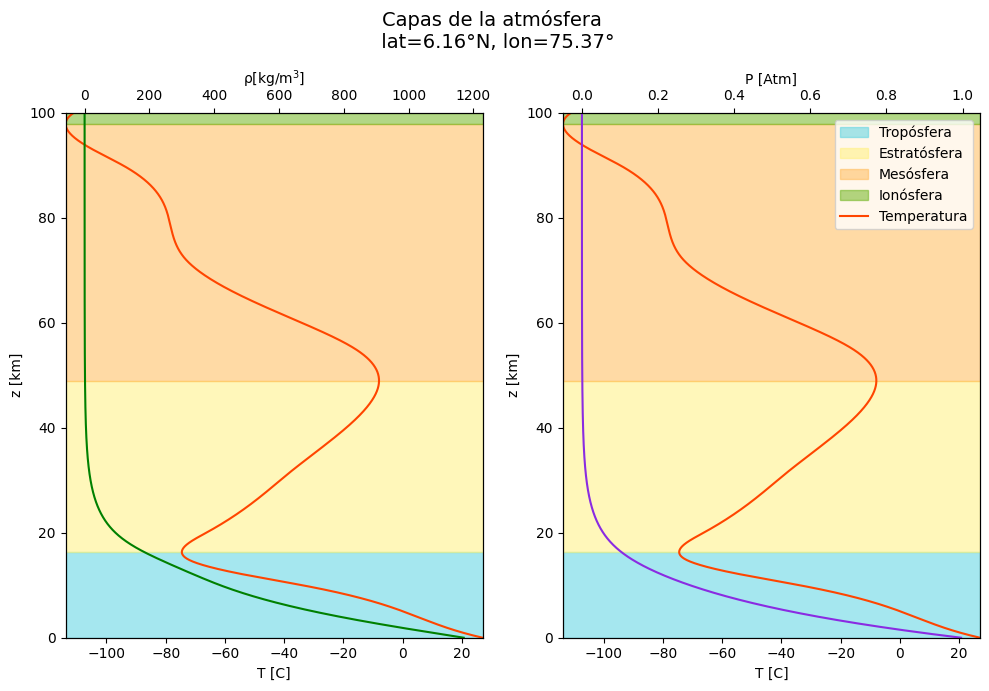

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,7))
plt.suptitle(f"Capas de la atmósfera \n lat={latitud:.2f}°N, lon={longitud:.2f}°",size=14)
# Dibujar el primer gráfico de temperatura y densidad
ax1.plot(Ts_emp-273.15,zs/1e3,color="orangered",label='Temperatura')
axd1=ax1.twiny()
axd1.plot(ρs_emp*1e3,zs/1e3,color="green",label="Densidad")

# Decoración grafica 1
ax1.set_xlabel("T [C]")
ax1.set_ylabel("z [km]")
axd1.set_xlabel("ρ[kg/m$^3$]")
ax1.margins(0,0)
ax1.set_ylim(0,max(zs)/1e3)

lim1 = ax1.get_xlim()

# Crear una secuencia de colores para el degradado
colores = ['#4DD0E1', '#FFF176', '#FFB74D', "#66B10F"]
labels= ["Tropósfera","Estratósfera","Mesósfera","Ionósfera"]
lim_zs = np.array([0,zs[ztp],zs[zep],zs[zmp],zs[-1]])/1e3


# Crear un degradado de colores entre las regiones
for i in range(0,4):
    ax1.fill_between(x=lim1, y1=lim_zs[i], y2=lim_zs[i+1], color=colores[i],alpha=0.5,label=labels[i] )
    ax2.fill_between(x=lim1, y1=lim_zs[i], y2=lim_zs[i+1], color=colores[i],alpha=0.5,label=labels[i])


# Dibujar el segundo gráfico de temperatura y presión
ax2.plot(Ts_emp-273.15,zs/1e3,color="orangered",label='Temperatura')
axd2=ax2.twiny()
axd2.plot(ps_emp/atm,zs/1e3,color="blueviolet",label="Presion")


# Decoración grafica 2
ax2.set_xlabel("T [C]")
ax2.set_ylabel("z [km]")
axd2.set_xlabel("P [Atm]")
ax2.margins(0,0)
ax2.set_ylim(0,max(zs)/1e3)
ax2.legend()
plt.tight_layout()
plt.show()

## Densidad con ajuste del modelo isotérmico

4. Haga un ajuste de la densidad atmosférica empírica como función de la altura en la tropósfera, usando el modelo isotérmico. Determine, por tanto, el valor de  $h_0$  y  $ρ_0$  que mejor se ajustan al perfil de densidad empírico.

La densidad en el modelo isotérmico está dada por:
$$\rho = \rho_0 e^{-z/h_0} $$

Donde $h_0= \frac{p_0}{\rho_0 g_0}$ es la escala vertical incompresible.



In [15]:

import numpy as np
from scipy.optimize import curve_fit

# Se define la función de ajuste del modelo isotérmico
def ρ_iso(z,ρo,ho):
    return ρo*np.exp(-z/ho)

def ajuste_iso(z,ρ,alt):

  # Ajuste con curvefit
  params_iso = curve_fit(ρ_iso,z[:alt]/1e3,ρ[:alt])[0]

  # El ajuste devuelve el valor de la densidad inicial y la escala vertical incompresible
  ρo_fit_iso,ho_iso = params_iso

  return([ρo_fit_iso,ho_iso])



Se obtienen los valores de $\rho_0$ y $h_0$ en el ajuste isotérmico y se calculan los datos ajustados

In [16]:
# Valores de densidad inicial y ho dado por el ajuste en la atmósfera isotérmica
ρo_fit_iso,ho_iso = ajuste_iso(zs,ρs_emp,ztp)

# Modelo de ajuste evaluado en los valores obtenidos
modelo = ρ_iso(zs[:ztp]/1e3,ρo_fit_iso, ho_iso)

print(f"El valor de ρo en el módelo isotérmico es: {ρo_fit_iso:.2f} [kg/m^3]")
print(f"El valor de ho en el módelo isotérmico  es: {ho_iso:.2f} [km]")

El valor de ρo en el módelo isotérmico es: 1.19 [kg/m^3]
El valor de ho en el módelo isotérmico  es: 9.45 [km]


Gráfica

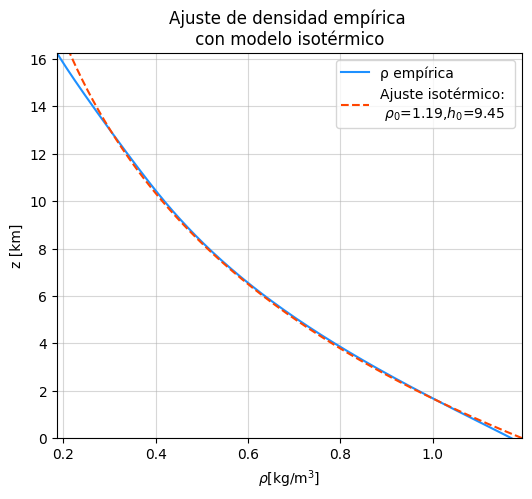

In [17]:
# Grafica para comparar la densidad con ajuste isotérmico y empírica en la tropopausa
plt.figure(figsize=(6,5))
plt.title(f"Ajuste de densidad empírica \n con modelo isotérmico ",size=12)
plt.plot(ρs_emp[:ztp],zs[:ztp]/1e3,color="dodgerblue",label="ρ empírica",markersize=0.5)
plt.plot(modelo,zs[:ztp]/1e3,color="orangered",linestyle="--",label=f"Ajuste isotérmico: \n $ρ_0$={ρo_fit_iso:.2f},$h_0$={ho_iso:.2f}")
plt.xlabel("$ρ$[kg/m$^3$]")
plt.ylabel("z [km]")
plt.margins(0,0)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## Presión con ajuste del modelo isotérmico

5. Con ese valor de $\rho_0$ y $h_0$ grafique la presión esperada según el modelo isotérmico. Para ello use el valor de $p_0$ que se sigue de la definición $h_0 = p_0/(\rho_0 g_0)$ y por otro lado la presión superficial empírica. Compare ambas curvas con la curva de presión empírica.


La escala vertical incompresible se define como :

$$h_0 = \frac{p_0}{g_0 \rho_0}$$

Despejando la presión en la superficie $p_0$:

$$p_0 = h_0 g_0 \rho_0$$

Se definen las funciones para calcular la presión en el modelo isotérmico y la presión inicial.

In [18]:
def presion_iso(z,po,ho,alt):
  return po*np.exp(-z[:alt]/(1e3*ho))

def presion0(ρo,ho):
  go = 9.8
  return go*ρo*ho*1e3

Se calculan las presiones

In [19]:
# Cálculo de la presión inicial en atmósfera isotérmica, en pascales
po_fit_iso = presion0(ρo_fit_iso,ho_iso)

# Valores de presión en función de la altura con el po calculado con el ho del ajuste isotérmico
ps_iso_fit = presion_iso(zs,po_fit_iso,ho_iso,ztp)

#Valores de presión en función de la altura con la presión inicial dada por la presión empírica
ps_iso_emp = presion_iso(zs,ps_emp[0],ho_iso,ztp)

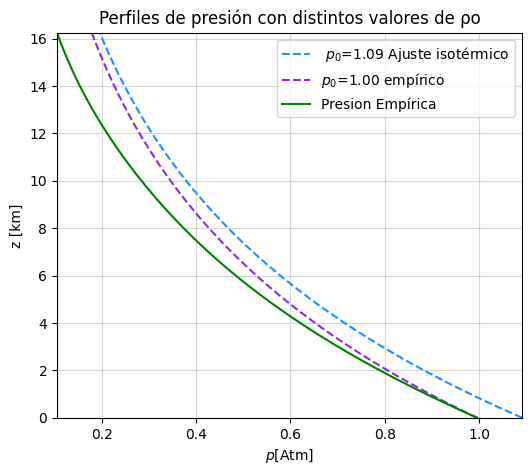

In [20]:
## Gráfico de las presiones
plt.figure(figsize=(6,5))
plt.title("Perfiles de presión con distintos valores de ρo" )
plt.plot(ps_iso_fit/atm,zs[:ztp]/1e3,color="dodgerblue",linestyle="--",label=f" $p_0$={po_fit_iso/atm:.2f} Ajuste isotérmico")
plt.plot(ps_iso_emp/atm,zs[:ztp]/1e3,color="blueviolet",linestyle="--",label=f"$p_0$={ps_emp[0]/atm:.2f} empírico ")
plt.plot(ps_emp[:ztp]/atm,zs[:ztp]/1e3,color="green",label="Presion Empírica")
plt.xlabel("$p$[Atm]")
plt.ylabel("z [km]")
plt.margins(0,0)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## Densidad y presión con ajuste del modelo homentrópico

### Densidad

El modelo homentrópico de la atmósfera permite conocer la densidad de la atmósfera en función de la altura está dado por:

$$ ρ(z) =  ρo (1-\frac{z}{h_2})^{\frac{1}{γ-1}}$$

Donde γ es el indice adiabático, $ρ_0$ la densidad en la superficie del planeta, y $h_2$ se define como:

$$h_2 = \frac{γ}{γ-1}h_0$$

Se define la función modelo para la densidad en el modelo homentrópico y se realiza el ajuste.

In [21]:
def ρ_hom(z,ρo,h2,γ):
    return ρo*(1-z/h2)**(1/(γ-1))


def ajuste_homent(z,ρ,alt):
  """
  Esta función recibe un arreglo de alturas, densidades y un límite
  para las alturas y retorna los valores ajustados de densidad inicial
  y ho
  """
  params0=[1.1,50,7/5]

  # Ajustar los datos al modelo homeontrópico
  params_home = curve_fit(ρ_hom,z[:alt]/1e3,ρ[:alt],p0=params0)[0]

  # Densidad inicial, h2 e indice adiabático
  ρo_fit,h2_fit,γ_fit = params_home
  return([ρo_fit,h2_fit,γ_fit ])


Se obtienen los parametros de $\rho_0$, $h_2$, $\gamma$ para el modelo homentrópico

In [22]:
# Parámetros del ajuste
ρo_fit_home,h2_fit,γ_fit = ajuste_homent(zs,ρs_emp,ztp)

# Curva de densidad ajustada con el modelo homentrópico
ρ_home=ρ_hom(zs[:ztp]/1e3,ρo_fit_home,h2_fit,γ_fit)

print(f"El valor de ρo en el módelo homentrópico es: {ρo_fit_home:.2f} [kg/ms³]")
print(f"El valor de h2 en el módelo homentrópico  es: {h2_fit:.2f} [km]")
print(f"El valor de γ en el módelo homentrópico es: {γ_fit:.2f}")

El valor de ρo en el módelo homentrópico es: 1.18 [kg/ms³]
El valor de h2 en el módelo homentrópico  es: 79.34 [km]
El valor de γ en el módelo homentrópico es: 1.13


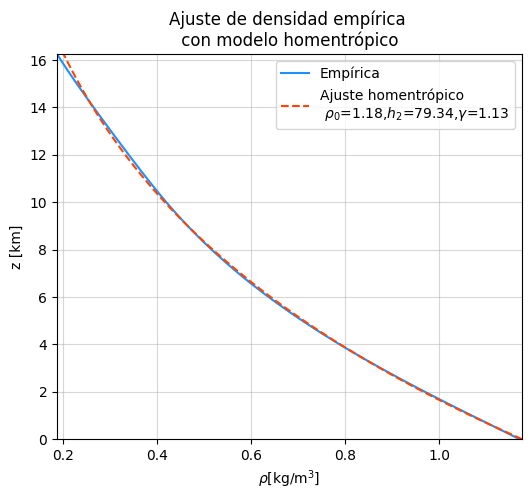

In [23]:
# graficas
plt.figure(figsize=(6,5))
plt.title(f"Ajuste de densidad empírica \n con modelo homentrópico ",size=12)
plt.plot(ρs_emp[:ztp],zs[:ztp]/1e3,color="dodgerblue",label="Empírica",markersize=0.5)
plt.plot(ρ_home,zs[:ztp]/1e3,color="orangered",linestyle="--",label=f"Ajuste homentrópico \n $ρ_0$={ρo_fit_home:.2f},$h_2$={h2_fit:.2f},$γ$={γ_fit:.2f}")
plt.xlabel("$ρ$[kg/m$^3$]")
plt.ylabel("z [km]")
plt.margins(0,0)
plt.grid(alpha=0.5)
plt.legend()
plt.show()


### Presión y $h_o$ en modelo homentrópico

La presión en un modelo homentrópico está dada por:
$$ p(z) =  po (1-\frac{z}{h_2})^{\frac{γ}{γ-1}}$$

 A partir de la ecuación para $h_2$ se puede hallar la escala vertical incompresible $h_0$ como:
 $$h_0 =  \frac{γ-1}{γ}h_2$$

In [24]:
# Escala vertical incompresible
def presion_homent(z,po,γ,h2,alt):
  return  po*(1-z[:alt]/(1e3*h2))**(γ/(γ-1))

def h0_home(γ,h2):
  return(h2*(γ-1)/γ)

# Valor de ho en la atmósfera empírica
go=9.8
ho_emp = ps_emp[0]/(ρs_emp[0]*go) /1e3

# Valor de ho en la atmósfera homentrópica
ho_home= h0_home(γ_fit,h2_fit)

# Valor de po en la atmósfera homentrópica
po_fit_home = presion0(ρo_fit_home,ho_home)

# Perfil de presión en la atmosfera homentrópica con po del ajuste
ps_home_fit = presion_homent(zs,po_fit_home,γ_fit,h2_fit,ztp)
# Perfil de presión en la atmosfera homentrópica con po de la atmósfera empírica
ps_home_emp = presion_homent(zs,ps_emp[0],γ_fit,h2_fit,ztp)

print(f"El valor de po en el módelo homentrópico es: {po_fit_home/atm:.2f} [atm]")
print(f"El valor de h0 en el módelo homentrópico  es: {ho_home:.2f} [km]")


El valor de po en el módelo homentrópico es: 1.03 [atm]
El valor de h0 en el módelo homentrópico  es: 9.10 [km]


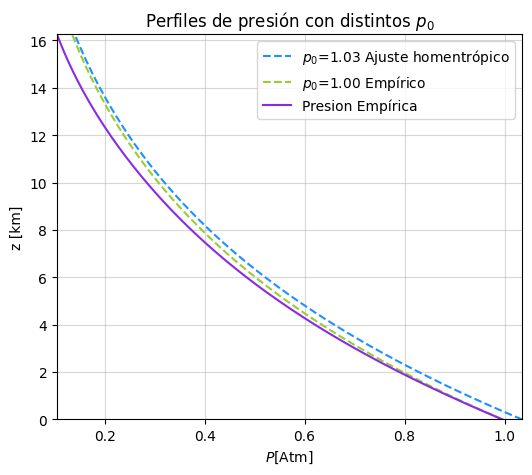

In [25]:
plt.figure(figsize=(6,5))
plt.title(f"Perfiles de presión con distintos $p_0$")
plt.plot(ps_home_fit/atm,zs[:ztp]/1e3,color="dodgerblue",linestyle="--",label=f"$p_0$={po_fit_home/atm:.2f} Ajuste homentrópico")
plt.plot(ps_home_emp/atm,zs[:ztp]/1e3,color="yellowgreen",linestyle="--",label=f"$p_0$={ps_emp[0]/atm:.2f} Empírico")
plt.plot(ps_emp[:ztp]/atm,zs[:ztp]/1e3,color="blueviolet",label="Presion Empírica")
plt.xlabel("$P$[Atm]")
plt.ylabel("z [km]")
plt.margins(0,0)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Comparación de los valores de $h_0$, $ \rho_0$ , $p_0$ para los distintos modelos

In [26]:

evi = pd.DataFrame()
evi["Modelo"]=["Isotérmico","Homentrópico","Empírico"]
evi["po [atm]"] = np.round([po_fit_iso/atm,po_fit_home/atm,ps_emp[0]/atm],2)
evi["ρo [kg/m³]"] = np.round([ρo_fit_iso,ρo_fit_home,ρs_emp[0]],2)
evi["ho [km]"] = np.round([ho_iso,ho_home,ho_emp],2)

evi

,Modelo,po [atm],ρo [kg/m³],ho [km]
0,Isotérmico,1.09,1.19,9.45
1,Homentrópico,1.03,1.18,9.10
2,Empírico,1.00,1.17,8.80


Se observa que el modelo homentrópico se ajusta mejor en densidad y presión al modelo empírico, este modelo considera variabilidad de la temperatura con la distancia y una relación de la presión con la densidad y viceversa, este modelo se asemeja más a la situación real de la atmósfera.

## Funciones que se derivan de los puntos anteriores

### Rutina para calcular ho

In [27]:

def ho_atmfs(z,fecha,lat,lon):

  #Calcula la atmósfera empírica
  ρs_emp,ps_emp,Ts_emp = atmosfera_emp(z,fecha,lat,lon)

  #almacenael indice de la la altura de la tropopausa
  ztp = tp(Ts_emp)

  #Calcula ho de la atmósfera isotérmica
  ho_iso = ajuste_iso(z,ρs_emp,ztp)[1]
  a,h2_home,γ_home = ajuste_homent(z,ρs_emp,ztp)
  ho_home = h0_home(γ_home,h2_home)
  data = [ho_iso,ho_home]

  return(data)



7. ¿Dependerá el valor de $h_0$ del lugar en la Tierra en el que estás el mismo día de tu nacimiento?. Repita el procedimiento 6 para otras 3 ciudades (aquellas a las que te soñarías viajar), ojala de latitudes geográficas diversas, es decir, cerca al ecuador, pero también en latitudes altas, al norte o al Sur ¿qué observas? ¿cómo lo interpretas?

### Rutina para calcular los ajustes de la atmósfera

In [28]:
def atm_modelos(z,fecha,lat,lon):

  #Calcula la atmósfera empírica
  ρs_emp,ps_emp,Ts_emp = atmosfera_emp(z,fecha,lat,lon)

  #almacenael indice de la la altura de la tropopausa
  ztp = tp(Ts_emp)




  #Calcula los perfiles de densidad y presión segun el ajuste con el modelo isotérmico
  ρo_iso,ho_iso = ajuste_iso(z,ρs_emp,ztp)
  ρs_iso = ρ_iso(z[:ztp]/1e3,ρo_iso, ho_iso)

  # Presión inicial
  po_iso = presion0(ρo_iso,ho_iso)
  # Perfil de presión en la atmosfera isotermica con po del ajuste
  ps_iso = presion_iso(z,po_iso,ho_iso,ztp)
  # Perfil de presión en la atmosfera isotérmica con po de la atmósfera empírica
  ps_iso_emp = presion_iso(z,ps_emp[0],ho_iso,ztp)



  #Calcula los perfiles de densidad y presión segun el ajuste con el modelo homentrópico
  ρo_home,h2_home,γ_home = ajuste_homent(z,ρs_emp,ztp)
  ρs_home = ρ_hom(z[:ztp]/1e3,ρo_home,h2_home,γ_home)


  # Valor de ho en la atmósfera empírica
  go=9.8
  ho_emp = ps_emp[0]/(ρs_emp[0]*go) /1e3

  # Valor de ho en la atmósfera homentrópica
  ho_home= h0_home(γ_home,h2_home)

  # Valor de po en la atmósfera homentrópica
  po_home = presion0(ρo_home,ho_home)

  # Perfil de presión en la atmosfera homentrópica con po del ajuste
  ps_home = presion_homent(z,po_home,γ_home,h2_home,ztp)
  # Perfil de presión en la atmosfera homentrópica con po de la atmósfera empírica
  ps_home_emp = presion_homent(z,ps_emp[0],γ_home,h2_home,ztp)

  # se alamacenan los perfiles del modelo homentrópico
  atm = 101325 # pascales
  model=pd.DataFrame()
  model["ztp"] = z[:ztp] /1e3
  model["ρ_emp"] = ρs_emp[:ztp]
  model["p_emp"] = ps_emp[:ztp]/atm
  model["ρ_isot"] = ρs_iso
  model["p_isot1"] =  ps_iso/atm
  model["p_isot2"] =  ps_iso_emp/atm
  model["ρ_home"] =  ρs_home
  model["p_home1"] =  ps_home /atm
  model["p_home2"] =  ps_home_emp /atm


  params = pd.DataFrame()
  params["modelo"]=["empirico","isotermico","homentropico"]
  params["ρo"] = [ρs_emp[0],ρo_iso,ρo_home]
  params["po"] = [ps_emp[0],po_iso,po_home]
  params["ho"] = [ho_emp,ho_iso,ho_home]

  return(model,params)

### Rutina para graficar los modelos de atmósferas

In [29]:
def plots_perfiles(model,ciudad,ztp,ho,ρ,p):
  # Crear subplots en una misma fila utilizando plt.subplots()
  fig, axes = plt.subplots(1, 2, figsize=(10, 6))

  # Gráfico 1
  axes[0].plot(ρ[:,0],ztp,linestyle='--',label=model[0])
  axes[0].plot(ρ[:,1],ztp,linestyle='--',label=model[1])
  axes[0].plot(ρ[:,2],ztp,label=model[2])
  axes[0].set_title("Perfil de Densidad Atmosférica " + ciudad)
  axes[0].set_xlabel("ρ [kg/m$³$]")
  axes[0].set_ylabel("z [km]")

  # Gráfico 2
  axes[1].plot(p[:,0],ztp,linestyle='--',label=model[1]+ f" $h_0$={ho[0]:.2f}")
  axes[1].plot(p[:,1],ztp,linestyle='--',label=model[2]+ f" $h_0$={ho[1]:.2f}")
  axes[1].plot(p[:,2],ztp,label=model[2])
  axes[1].set_title("Perfil de Presión Atmosférica "+ciudad)
  axes[1].set_xlabel("$P $[Atm]")


  for i in range(2):
    axes[i].grid(alpha=0.5)
    axes[i].legend()

  # Ajustar espacios entre subplots
  plt.tight_layout()
  # Mostrar la figura
  return(plt.show())



## Atmósfera en distintas localidades

## Ciudades

7. ¿Dependerá el valor de $h_0$ del lugar en la Tierra en el que estás el mismo día de tu nacimiento?. Repita el procedimiento 6 para otras 3 ciudades (aquellas a las que te soñarías viajar), ojala de latitudes geográficas diversas, es decir, cerca al ecuador, pero también en latitudes altas, al norte o al Sur ¿qué observas? ¿cómo lo interpretas?

Las ciudades que se escogieron fueron:

* Amsterdam Holanda: Lat:52.37403, Lon: 4.88969
* Montreal Canada: Lat:45.5088400, Lon: -73.5878100
* Mackay Australia:	Lat: -21.1411, Lon: 149.186



In [30]:
# Coordenadas de las ciudades
amsterdam=[52.37403,4.88969]
montreal=[45.5088400,-73.5878100]
mackay= [-21.1411, 149.186]
ciudad=["Amsterdan","Montreal","Mackay"]
model = ["Isotérmico","Homentrópico", "Empírico"]

date = datetime(2001, 2, 5)  # Fecha específica
zs = np.arange(0,100000,50)  # Altitudes en metros

#### Amsterdan

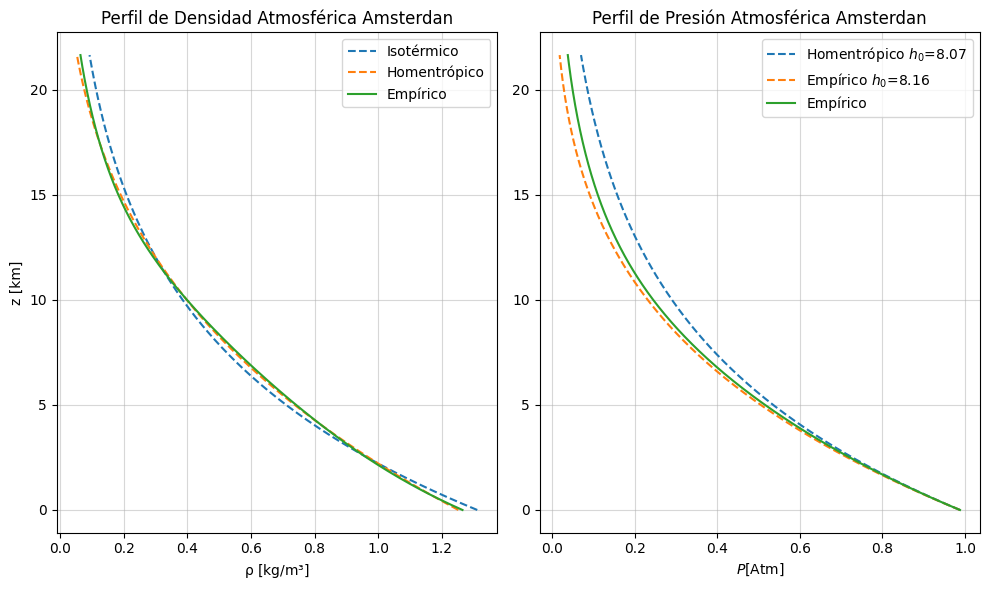

_____________________________________________________
ho isotérmico para Amsterdan 8.072 [km]
ho homentrópico para Amsterdan 8.159 [km]
_____________________________________________________


In [31]:
# Almacena los perfiles de densidad y presión con los distintos modelos para Amsterdam
atm_amst,ho_amst = atm_modelos(zs,date,amsterdam[0],amsterdam[1])

dens = atm_amst[["ρ_isot","ρ_home","ρ_emp"]].to_numpy()
pres = atm_amst[["p_isot2","p_home2","p_emp"]].to_numpy()
plots_perfiles(model,ciudad[0],atm_amst.ztp,ho_amst.ho,dens,pres)
print("_____________________________________________________")
print(f"ho isotérmico para "+ciudad[0] + f" {ho_amst.ho[0]:.3f} [km]")
print(f"ho homentrópico para "+ciudad[0] + f" {ho_amst.ho[1]:.3f} [km]")
print("_____________________________________________________")


### Montreal

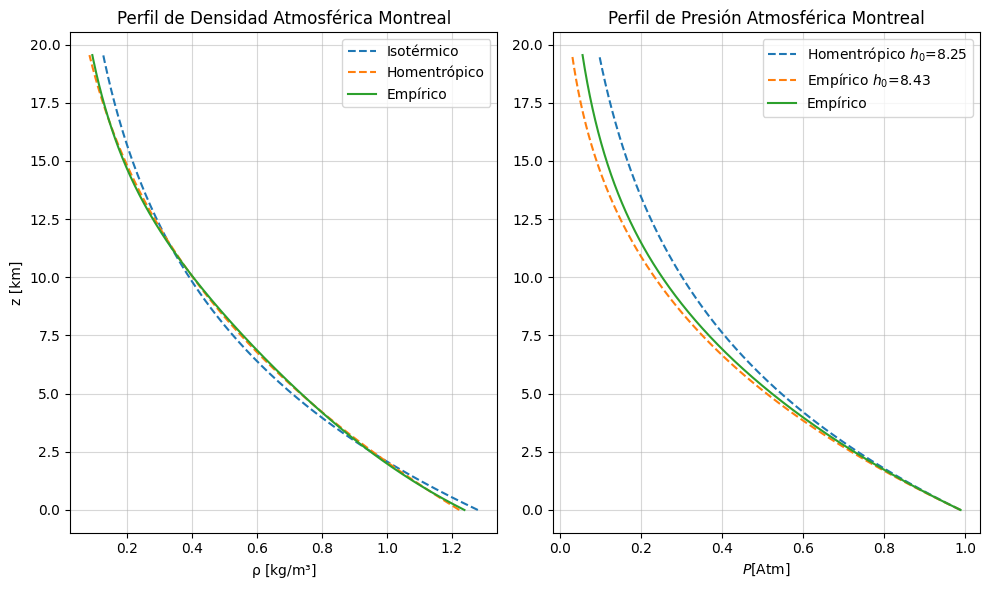

_____________________________________________________
ho isotérmico para Montreal 8.247 [km]
ho homentrópico para Montreal 8.432 [km]
_____________________________________________________


In [32]:
# Almacena los perfiles de densidad y presión con los distintos modelos para Montreal
atm_mont,ho_mont = atm_modelos(zs,date,montreal[0],montreal[1])

dens = atm_mont[["ρ_isot","ρ_home","ρ_emp"]].to_numpy()
pres = atm_mont[["p_isot2","p_home2","p_emp"]].to_numpy()
plots_perfiles(model,ciudad[1],atm_mont.ztp,ho_mont.ho,dens,pres)
print("_____________________________________________________")
print(f"ho isotérmico para "+ciudad[1] + f" {ho_mont.ho[0]:.3f} [km]")
print(f"ho homentrópico para "+ciudad[1] + f" {ho_mont.ho[1]:.3f} [km]")
print("_____________________________________________________")

### Mackay

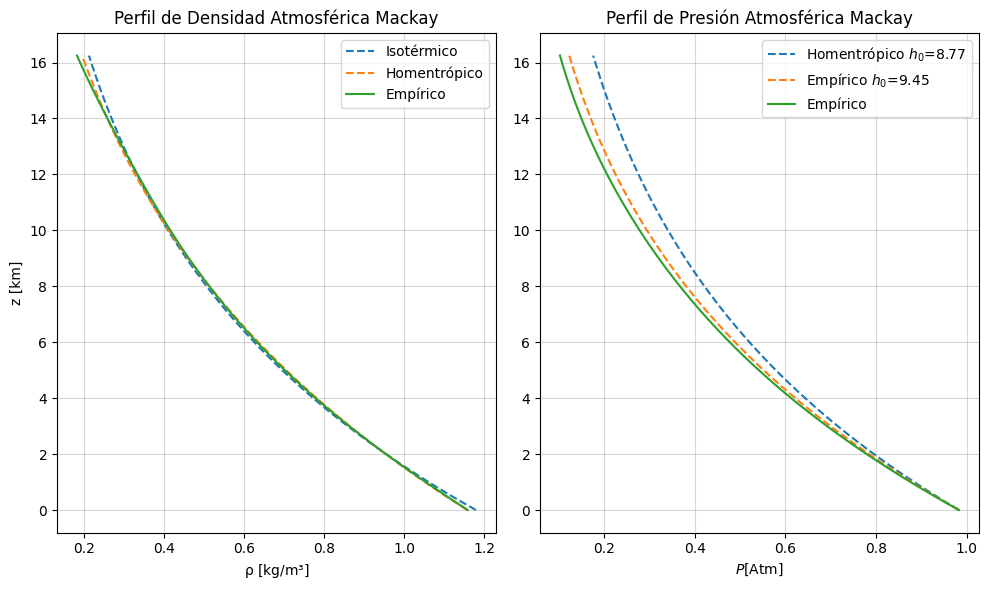

_____________________________________________________
ho isotérmico para Mackay 8.773 [km]
ho homentrópico para Mackay 9.450 [km]
_____________________________________________________


In [33]:
# Almacena los perfiles de densidad y presión con los distintos modelos para Mackay
atm_mack,ho_mack = atm_modelos(zs,date,mackay[0],mackay[1])

dens = atm_mack[["ρ_isot","ρ_home","ρ_emp"]].to_numpy()
pres = atm_mack[["p_isot2","p_home2","p_emp"]].to_numpy()
plots_perfiles(model,ciudad[2],atm_mack.ztp,ho_mack.ho,dens,pres)
print("_____________________________________________________")
print(f"ho isotérmico para "+ciudad[2] + f" {ho_mack.ho[0]:.3f} [km]")
print(f"ho homentrópico para "+ciudad[2] + f" {ho_mack.ho[1]:.3f} [km]")
print("_____________________________________________________")

Se observa que el valor de $h_0$ depende de la latitud, esto puede deberse a que en una misma epoca del año la duración del recorrido del sol sobre la bóveda celeste varía con la latitud, esto produce los solsticios y equinocciós que repercuten en la temperatura y esta a su vez en el tamaño de la atmósfera.

## $h_0$ y las estaciones

8. ¿Dependerá el valor de $h_0$ de la fecha del año?. Toma 2 ciudades, una cerca al ecuador y otra en una latitud alta (ojalá por encima de los 45 grados de latitud norte o sur) y determina $h_0$ en verano y en invierno (siempre a la misma hora, el medio día) ¿qué observas? ¿cómo lo interpretas?

Las ciudades escogidas fueron:

* Quito Ecuador: Longitud: -78.5249500 Latitud: -0.2298500

* fairbanks en Alaska EE.UU: Longitud: 64.83778, Latitud: -147.71639

In [34]:
from datetime import datetime, timedelta

#Coordenadas de las ciudades:  [lat,lon]
quito = [-0.2298500, 78.5249500, ]
fairbanks= [64.8378, -147.7164]


fecha_inicio = datetime(2020, 1, 1)
fecha_fin = datetime(2020, 12, 31)

# Generar el rango de fechas
fechas = [fecha_inicio + timedelta(days=i*5) for i in range(int(365/5))]

zs = np.arange(0,220000,50)  # Altitudes en metros

In [35]:
from datetime import date, timedelta
# Crea un rango de días para todo el año en una sola línea
fechas = [datetime(2001, 1, 1) + timedelta(days=d*5) for d in range(int(365/5))]

ho_fairbks = np.zeros((len(fechas),2))
ho_quito = np.zeros((len(fechas),2))
for i in tqdm(range(len(fechas)), desc="Haciendo la magia", unit="days"):
  ho_fairbks[i] = ho_atmfs(zs,fechas[i],fairbanks[0],fairbanks[1])
  ho_quito[i] = ho_atmfs(zs,fechas[i],quito[0],quito[1])

Haciendo la magia: 100%|██████████| 73/73 [03:21<00:00,  2.76s/days]


In [36]:
# Fechas de las estaciones y valor de ho en cada estación para ambas ciudades

verano = datetime(2001,6,24,0,0)
invierno =  datetime(2001,12,24,0,0)


ho_verano_quito = ho_atmfs(zs,verano,quito[0],quito[1])
ho_invierno_quito = ho_atmfs(zs,invierno,quito[0],quito[1])

ho_verano_fairbks = ho_atmfs(zs,verano,fairbanks[0],fairbanks[1])
ho_invierno_fairbks = ho_atmfs(zs,invierno,fairbanks[0],fairbanks[1])

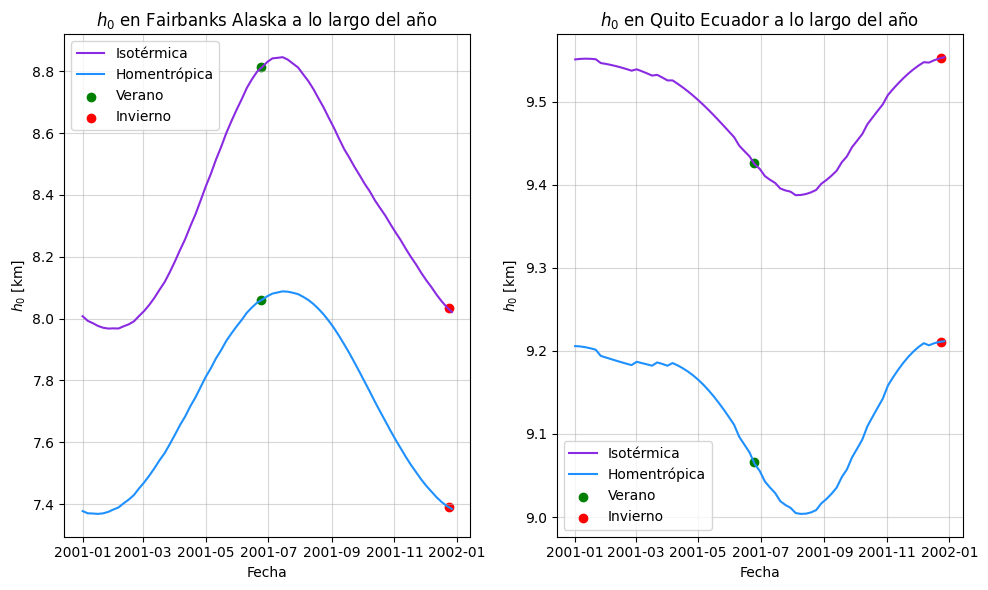

In [37]:
# Almacena los perfiles de densidad y presión con los distintos modelos para Montreal

# Crear subplots en una misma fila utilizando plt.subplots()
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Gráfico 1
axes[0].plot(fechas,ho_fairbks[:,0],label=f"Isotérmica",color="blueviolet")
axes[0].plot(fechas,ho_fairbks[:,1], label=f"Homentrópica",color="dodgerblue")

# Puntos de verano e invierno
axes[0].scatter(verano,ho_verano_fairbks[0],label=f"Verano",color="green")
axes[0].scatter(invierno,ho_invierno_fairbks[0],color="red")

axes[0].scatter(verano,ho_verano_fairbks[1],color="green")
axes[0].scatter(invierno,ho_invierno_fairbks[1],label=f"Invierno",color="red")

# Decoración
axes[0].set_title('$h_0$ en Fairbanks Alaska a lo largo del año')
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("$h_0$ [km]")

# Gráfico 2
axes[1].plot(fechas,ho_quito[:,0],label=f"Isotérmica",color="blueviolet")
axes[1].plot(fechas,ho_quito[:,1],label=f"Homentrópica",color="dodgerblue")

# Puntos de verano e invierno
axes[1].scatter(verano,ho_verano_quito[0],label=f"Verano",color="green")
axes[1].scatter(invierno,ho_invierno_quito[0],color="red")

axes[1].scatter(verano,ho_verano_quito[1],color="green")
axes[1].scatter(invierno,ho_invierno_quito[1],label=f"Invierno",color="red")

axes[1].set_title('$h_0$ en Quito Ecuador a lo largo del año')
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("$h_0$ [km]")

for i in range(2):
  axes[i].grid(alpha=0.5)
  axes[i].legend()
  #axes[i].margins(0,0)
# Ajustar espacios entre subplots

plt.tight_layout()

# Mostrar la figura
plt.show()


En el análisis de Fairbanks, una ciudad situada en una latitud elevada, hemos observado que el parámetro $h_0$ experimenta un aumento a lo largo del año en ambos modelos, alcanzando su punto máximo cerca del solsticio de verano en el hemisferio norte. Por el contrario, cerca del solsticio de invierno, registra su valor mínimo en ambas simulaciones atmosféricas. Es importante destacar que en el modelo homentrópico, la variación de $h_0$ es menor en comparación con el modelo isotérmico.

En el caso de Quito, Ecuador, notamos que $h_0$ varía muy poco (aproximadamente 200 metros) en ambos modelos. Es interesante observar que dado que Quito se encuentra al sur del ecuador, durante el solsticio de verano, el sol se encuentra en su máxima inclinación hacia el norte al mediodía. Esto se refleja en el valor de $h_0$, que se acerca al mínimo en las fechas cercanas al solsticio de verano. Por otro lado, durante el solsticio de invierno, ocurre lo contrario, y el valor de $h_0$ se aproxima a su máximo.

En resumen, podemos concluir que el valor de $h_0$ está estrechamente vinculado a las estaciones del año. Esta relación se manifiesta en la expansión o contracción de la atmósfera, que indica la variación de $h_0$. Cuando el sol permanece durante más horas al día sobre un lugar de la Tierra, tiende a calentar la atmósfera, lo que provoca su expansión. Esta dinámica explica las fluctuaciones estacionales observadas en el valor de $h_0$.

## $h_0$ y el Ciclo Solar


9. ¿Dependerá el valor de $h_0$ de la actividad solar?. Toma otras vez las 2 ciudades de 8 y determina el valor de $h_0$ en la fecha del perihelio de un año de mínimo de actividad solar y uno de máximo de actividad solar ¿qué observas?. Repite lo mismo pero comparando la densidad atmosférica a 100 km de altura en ambas fechas ¿hay cambios?


Se escogió el ciclo solar 24 que tuvo su mínimo solar en 2008  siendo la fecha del perihelio el 3 de enero, luego el máximo de este ciclo solar se da en el 2014 y el perihelio de este año se dio el 4 de enero,  veamos como varía $h_0$

Fuente: https://www.tutiempo.net/astronomia/afelio-perihelio/2014.html


In [42]:
date_min = datetime(2008,1,3)
date_max = datetime(2014,1,4)
lat =np.arange(-90,90,10)

ho_minsolar= np.zeros((len(lat),2))
ho_maxsolar= np.zeros((len(lat),2))


ho_minsolar = ho_atmfs(zs,date_min,fairbanks[0],fairbanks[1])
ho_maxsolar = ho_atmfs(zs,date_max,fairbanks[0],fairbanks[1])

df=pd.DataFrame()
df["Época"]=["Minimo solar","Maximo solar"]
df["ho isot [km]"] = [ho_minsolar[0],ho_maxsolar[0]]
df["ho homent [km]"] = [ho_minsolar[1],ho_maxsolar[1]]
df

,Época,ho isot [km],ho homent [km]
0,Minimo solar,7.998083,7.371095
1,Maximo solar,7.995550,7.369988


Densidad de partículas a 100km

In [39]:
date =[date_min,date_max]
dens= np.zeros(2)

for i , d in enumerate(date):
  dens[i] = atmosfera_emp(100,d,fairbanks[0],fairbanks[1])[0]

print(f"La densidad a 100km de altura en el mínimo solar es: {dens[0]:e} [kg/m³]")
print(f"La densidad a 100km de altura en el máximo solar es: {dens[1]:e} [kg/m³]")

La densidad a 100km de altura en el mínimo solar es: 1.333182e+00 [kg/m³]
La densidad a 100km de altura en el máximo solar es: 1.340391e+00 [kg/m³]


Se puede observar que el valor de $h_0$ y la densidad se mantiene casi constante independientemente de la actividad solar, ya que tanto en los mínimos como en los máximos solares se obtienen valores idénticos para este parámetro. A pesar de que durante un mínimo solar la densidad de partículas emitidas por el sol es menor que durante un máximo solar, podría pensarse que esto tendría un impacto en el tamaño de la atmósfera. Sin embargo, el campo magnético terrestre actúa como un constante escudo ante la influencia del viento solar, a menos que se produzca una super eyección de masa coronal. Por lo tanto, el viento solar tiene un efecto insignificante en el tamaño de la atmósfera como se observó en los resultados.

El parámetro $h_0$ guarda relación con la altura de la atmósfera y, como se observó previamente, aumenta con la temperatura del lugar según la estación del año.

## $h_0$ en función de la latitud

In [40]:
zs = np.arange(0,30000,1)
lat = np.arange(-90,90,1)
fecha = datetime(2001,2,5,0,0)
ho_lat= np.zeros((len(lat),2))
for i in tqdm(range(len(lat)), desc="Haciendo la magia", unit="days"):
  ho_lat[i] = ho_atmfs(zs,fecha,lat[i],0)


Haciendo la magia: 100%|██████████| 180/180 [07:56<00:00,  2.64s/days]


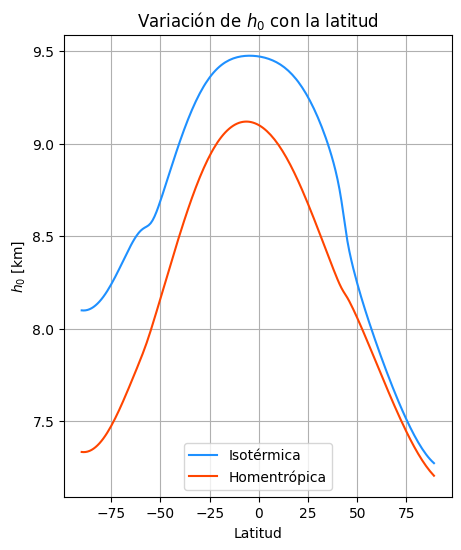

In [41]:
plt.figure(figsize=(5,6))
plt.title("Variación de $h_0$ con la latitud")
plt.plot(lat,ho_lat[:,0],color="dodgerblue",label="Isotérmica")
plt.plot(lat,ho_lat[:,1],color="orangered",label="Homentrópica")
plt.xlabel("Latitud")
plt.ylabel("$h_0$ [km]")
plt.legend()
plt.grid()

La diferencia en la altura de la atmósfera entre el ecuador y los polos puede deberse a las variaciones en la temperatura y la dinámica atmosférica a lo largo de la latitud. En el ecuador, la temperatura promedio es más alta que en los polos, debido a la exposición constante al calor solar directo a lo largo del año. Cuando las moléculas de aire se calientan, tienden a expandirse y elevarse, lo que da como resultado una atmósfera más alta en el ecuador.

Además, la rotación de la Tierra también juega un papel importante en esta diferencia. En el ecuador, la velocidad de rotación es máxima, lo que contribuye a una mayor expansión de la atmósfera debido al efecto centrífugo. Esto significa que en el ecuador, la atmósfera se extiende a altitudes superiores en comparación con los polos.

Otro factor podría ser la dinámica atmosférica. En el ecuador, se produce una convección atmosférica más intensa, con el aire caliente que asciende y luego se desplaza hacia los polos en altitudes superiores antes de descender en esas regiones. Esta circulación atmosférica también contribuye a una atmósfera más alta en el ecuador en comparación con los polos.

Prof. Jorge Ivan Zuluaga
